In [ ]:
#@title Install required packages
!pip install nltk emoji pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.0 MB/s eta 0:00:00


In [ ]:
# @title Import libraries and download NLTK data
import re
import emoji
import nltk
import pandas as pd
import unicodedata
import json
import os
from google.colab import files
from google.colab import drive

# Download NLTK data
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
print("✓ NLTK data downloaded!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✓ NLTK data downloaded!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# @title Mount Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Remove phone number from dataset
def remove_phone_numbers(text):
    """ phone number removal with multiple formats"""
    phone_patterns = [
        # Context-aware patterns - remove the whole phrase
        r'call\s+me\s+at\s+[\d\s\-\(\)\+\.]+(?:\s+or\s+[\d\s\-\(\)\+\.]+)?(?:\s+if\s+you\s+need\s+help)?',
        r'you\s+can\s+reach\s+me\s+at\s+[\d\s\-\(\)\+\.]+',
        r'reach\s+me\s+at\s+[\d\s\-\(\)\+\.]+',
        r'my\s+phone\s+is\s+[\d\s\-\(\)\+\.]+',
        r'phone\s+is\s+[\d\s\-\(\)\+\.]+',
        r'contact\s+me\s+at\s+[\d\s\-\(\)\+\.]+',

        # Standalone phone patterns
        r'\+\d{1,4}[-.\s]?\d{3,4}[-.\s]?\d{3,4}[-.\s]?\d{3,4}',
        r'\(\d{3}\)[-.\s]?\d{3}[-.\s]?\d{4}',
        r'\b\d{3}[-.\s]\d{3}[-.\s]\d{4}\b',
        r'\b\d{3}[-.\s]\d{4}\b',
        r'\b\d{10,11}\b',
    ]

    cleaned_text = text
    for pattern in phone_patterns:
        cleaned_text = re.sub(pattern, '', cleaned_text, flags=re.IGNORECASE)

    # Clean up extra spaces and conjunctions left hanging
    cleaned_text = re.sub(r'\s+or\s+if\s+you\s+need\s+help\s*', ' if you need help', cleaned_text)
    cleaned_text = re.sub(r'^\s*or\s+', '', cleaned_text)  # Remove leading "or"
    cleaned_text = re.sub(r'\s+but\s*$', '', cleaned_text)  # Remove trailing "but"
    cleaned_text = re.sub(r'^\s*but\s+', '', cleaned_text)  # Remove leading "but"
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [ ]:
# @title Text formatting functions
def fix_sentence_capitalization(text):
    """Fix capitalization after periods, exclamation marks, and question marks"""
    if not text:
        return text

    # Split into sentences and capitalize each
    sentences = re.split(r'([.!?])', text)
    result = []

    for i, part in enumerate(sentences):
        if part.strip() and part not in '.!?':
            part = part.strip()
            if part:
                # Capitalize first letter and handle "i" specifically
                part = part[0].upper() + part[1:] if len(part) > 1 else part.upper()

                # Fix standalone "i" to "I"
                part = re.sub(r'\bi\b', 'I', part)
                result.append(part)
        elif part in '.!?':
            result.append(part)

    return ' '.join(result).strip()

In [ ]:

# @title Sentence ending
def ensure_sentence_endings(text):
    """Ensure sentences end with proper punctuation"""
    if not text:
        return text

    # Remove trailing whitespace
    text = text.strip()

    # If text doesn't end with punctuation, add period
    if text and text[-1] not in '.!?':
        text += '.'

    return text

def fix_spacing_around_punctuation(text):
    """Fix spacing around punctuation marks"""
    # Remove spaces before punctuation
    text = re.sub(r'\s+([.!?,:;])', r'\1', text)

    #  space after punctuation
    text = re.sub(r'([.!?,:;])(?=[a-zA-Z])', r'\1 ', text)

    # Fix multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
# @title Enhanced encoding
def fix_encoding_issues(text):
    """Fix common encoding issues and recover corrupted emojis"""
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Manual fixes for common encoding artifacts
    encoding_fixes = {
        'â€™': "'",
        'â€œ': '"',
        'â€': '"',
        'â€"': '-',
        'â€¦': '...',
        'Â': ' ',
        'Ã¡': 'a',
        'Ã©': 'e',
        'Ã­': 'i',
        'Ã³': 'o',
        'Ãº': 'u',
        'Ã±': 'n',
        '\r\n': ' ',
        '\n': ' ',
        '\r': ' ',
    }

    fixed = text
    for artifact, replacement in encoding_fixes.items():
        fixed = fixed.replace(artifact, replacement)

    #   recover common corrupted emoji patterns by removing them
    emoji_patterns_to_remove = [
        'Ã°Ã¿',
        'Ã°Ã¿‹',
        'Ã°Ã¿˜',
        'Ã°Ã¿Œ',
        'Ã°Ã¿',
        'Ã°Ã¿˜­',
        'Ã°Ã¿˜‚',
        'Ã°Ã¿˜Š',
        'Ã°Ã¿˜ƒ',
        'Ã°Ã¿˜†',
        'Ã°Ã¿¤£',
    ]

    for pattern in emoji_patterns_to_remove:
        fixed = fixed.replace(pattern, ' ')

    # Remove any remaining unrecovered encoding artifacts
    fixed = re.sub(r'Ã[^\w\s]', ' ', fixed)

    return fixed

In [ ]:
# @title Abbreviation Expansion
def expand_abbreviations(text):
    """Expand common text abbreviations and internet slang"""
    abbreviations = {
        # Time expressions
        'rn': 'right now',
        'asap': 'as soon as possible',
        'rq': 'right quick',
        'ttyl': 'talk to you later',
        'brb': 'be right back',
        'gtg': 'got to go',
        'g2g': 'got to go',

        # Common phrases
        'tbh': 'to be honest',
        'imo': 'in my opinion',
        'imho': 'in my humble opinion',
        'btw': 'by the way',
        'fyi': 'for your information',
        'omg': 'oh my god',
        'wtf': 'what the hell',
        'wtaf': 'what the hell',
        'smh': 'shaking my head',
        'fml': 'my life sucks',
        'yolo': 'you only live once',
        'nvm': 'never mind',
        'nvrmnd': 'never mind',
        'idc': 'i do not care',
        'idgaf': 'i do not care',
        'l8r': 'later',
        'idk': 'i do not know',  # Added this missing one!

        # Reactions/emotions
        'lol': 'laughing',
        'lmao': 'laughing',
        'lmfao': 'laughing hard',
        'rofl': 'laughing',
        'haha': 'laughing',
        'omfg': 'oh my god',
        'jk': 'just kidding',
        'ily': 'i love you',
        'ilu': 'i love you',
        'bff': 'best friend',
        'bae': 'babe',
        'bf': 'boyfriend',  # Added this missing one!

        # Questions/responses
        'wyd': 'what are you doing',
        'wbu': 'what about you',
        'hbu': 'how about you',
        'sup': 'what is up',
        'wassup': 'what is up',
        'nbd': 'no big deal',
        'thx': 'thanks',
        'ty': 'thank you',
        'yw': 'you are welcome',
        'np': 'no problem',
        'ikr': 'i know right',
        'tmi': 'too much information',

        # Internet slang
        'af': 'very',
        'fr': 'for real',
        'irl': 'in real life',
        'tfw': 'that feeling when',
        'mfw': 'my face when',
        'mrw': 'my reaction when',
        'til': 'today i learned',
        'eli5': 'explain like i am five',
        'ama': 'ask me anything',
        'dae': 'does anyone else',

        # Social media
        'dm': 'direct message',
        'pm': 'private message',
        'rt': 'retweet',
        'mt': 'modified tweet',
        'ff': 'follow friday',
        'fb': 'facebook',
        'ig': 'instagram',
        'insta': 'instagram',

        # Other common ones
        'aka': 'also known as',
        'etc': 'and so on',
        'vs': 'versus',
        'w/': 'with',
        'w/o': 'without',
        'b4': 'before',
        'b/c': 'because',
        'bc': 'because',
        'ur': 'your',
        'u': 'you',
        'r': 'are',
        'ppl': 'people',
        'plz': 'please',
        'pls': 'please',
        'thru': 'through',
        'tho': 'though',
        'gonna': 'going to',
        'wanna': 'want to',
        'gotta': 'got to',
        'dunno': 'do not know',
        'kinda': 'kind of',
        'sorta': 'sort of',
        'outta': 'out of',
        'shoulda': 'should have',
        'woulda': 'would have',
        'coulda': 'could have'
    }

    # Apply abbreviation expansion (case insensitive)
    text_lower = text.lower()
    for abbr, expansion in abbreviations.items():
        # Use word boundaries to avoid partial matches
        pattern = r'\b' + re.escape(abbr) + r'\b'
        text_lower = re.sub(pattern, expansion, text_lower)

    return text_lower

In [ ]:
# @title Contraction Expansion
def expand_contractions(text):
    """Expand contractions like I've -> I have"""
    contractions = {
        "ain't": "is not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
        "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
        "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
        "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
        "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is",
        "let's": "let us", "she'd": "she would", "she'll": "she will", "she's": "she is",
        "shouldn't": "should not", "that's": "that is", "there's": "there is",
        "they'd": "they would", "they'll": "they will", "they're": "they are",
        "they've": "they have", "we'd": "we would", "we're": "we are", "we've": "we have",
        "weren't": "were not", "what's": "what is", "where's": "where is", "who's": "who is",
        "won't": "will not", "wouldn't": "would not", "you'd": "you would", "you'll": "you will",
        "you're": "you are", "you've": "you have", "'cause": "because", "'em": "them"
    }

    text_lower = text.lower()
    for contraction, expansion in contractions.items():
        pattern = r'\b' + re.escape(contraction) + r'\b'
        text_lower = re.sub(pattern, expansion, text_lower)

    return text_lower

In [ ]:
# @title Complete Text Cleaning Pipeline
def clean_therapy_text(text):
    """
    Enhanced therapy text cleaning with phone number removal and proper formatting
    """
    # Check for invalid input
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Start cleaning
    cleaned = text

    # FIRST: Fix encoding issues
    cleaned = fix_encoding_issues(cleaned)

    # Normalize Unicode characters
    cleaned = unicodedata.normalize('NFKD', cleaned)

    # Remove URLs
    cleaned = re.sub(r'http[s]?://[^\s]+', '', cleaned)
    cleaned = re.sub(r'www\.[^\s]+', '', cleaned)

    # Remove emails
    cleaned = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', cleaned)

    # Enhanced phone number removal
    cleaned = remove_phone_numbers(cleaned)

    # Remove mentions and hashtags (preserve content)
    cleaned = re.sub(r'@\w+', '', cleaned)
    cleaned = re.sub(r'#(\w+)', r'\1', cleaned)

    # Convert real emojis to descriptive text (preserve emotional context)
    cleaned = emoji.demojize(cleaned, delimiters=(" ", " "))

    # Clean up emoji text formatting
    cleaned = re.sub(r':', '', cleaned)  # Remove colons from :face_with_tears_of_joy:
    cleaned = re.sub(r'_', ' ', cleaned)  # Convert underscores to spaces

    # Expand contractions BEFORE abbreviations to avoid conflicts
    cleaned = expand_contractions(cleaned)

    # Expand abbreviations and internet slang
    cleaned = expand_abbreviations(cleaned)

    # Remove special characters - keep only letters, numbers, spaces, and basic punctuation
    cleaned = re.sub(r'[^a-zA-Z0-9\s!?.,\'-]', '', cleaned)

    # Remove multiple punctuation marks in a row but preserve single ones
    cleaned = re.sub(r'[!?.,\'-]{3,}', ' ', cleaned)

    # Clean whitespace (including multiple spaces, tabs, newlines)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    # Remove leading/trailing punctuation from words
    cleaned = re.sub(r'\b[!?.,\'-]+\b', '', cleaned)

    # Fix spacing around punctuation
    cleaned = fix_spacing_around_punctuation(cleaned)

    # Fix sentence capitalization
    cleaned = fix_sentence_capitalization(cleaned)

    # Ensure proper sentence endings
    cleaned = ensure_sentence_endings(cleaned)

    # Final whitespace cleanup
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    return cleaned

In [ ]:
# @title JSON Data Parsing
def parse_therapy_json(file_path):
    """Parse therapy JSON data from file"""
    data = []

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Split by lines and try to parse each as JSON
    lines = content.strip().split('\n')

    for line_num, line in enumerate(lines, 1):
        if line.strip():
            try:
                entry = json.loads(line)
                if 'Context' in entry and 'Response' in entry:
                    data.append({
                        'context': entry['Context'].strip(),
                        'response': entry['Response'].strip()
                    })
            except json.JSONDecodeError as e:
                print(f"Warning: Could not parse line {line_num}: {str(e)[:50]}...")
                # Try to parse manually for malformed JSON
                if '"Context":' in line and '"Response":' in line:
                    try:
                        # Manual parsing for malformed JSON
                        context_start = line.find('"Context":"') + 11
                        context_end = line.find('","Response":"')
                        response_start = context_end + 13
                        response_end = line.rfind('"}')

                        if context_end > context_start and response_end > response_start:
                            context = line[context_start:context_end]
                            response = line[response_start:response_end]

                            data.append({
                                'context': context.strip(),
                                'response': response.strip()
                            })
                    except Exception as manual_e:
                        print(f"Manual parsing also failed for line {line_num}")
                        continue

    return data

In [ ]:
# @title Encoding Artifact Detection
def inspect_encoding_artifacts(df, column_names=['context', 'response'], sample_size=1000):
    """Specifically look for encoding artifacts in therapy data"""
    artifacts = []

    for column in column_names:
        if column in df.columns:
            sample_texts = df[column].dropna().sample(min(sample_size, len(df)))

            # Look for common encoding patterns
            for text in sample_texts:
                if 'Ã' in text:
                    artifacts.append((column, text))

    print(f"Found {len(artifacts)} texts with potential encoding issues:")
    for i, (col, text) in enumerate(artifacts[:5], 1):  # Show first 5
        print(f"{i}. [{col}] {text[:100]}...")

    return artifacts


In [ ]:
# @title Main preprocessing function for JSONL files
import pandas as pd
import os
import json
import traceback

def preprocess_therapy_dataset(input_file, output_file=None):
    """Load, clean, and save therapy dataset"""

    print("=" * 50)

    # Step 1: Check input file
    print(f"1️ Checking input file: {input_file}")
    if not os.path.exists(input_file):
        print(f" Input file does not exist: {input_file}")

        # Show what files are available in the directory
        input_dir = os.path.dirname(input_file)
        if os.path.exists(input_dir):
            print(f" Files in {input_dir}:")
            for file in os.listdir(input_dir):
                print(f"   - {file}")
        return None

    print(f" Input file exists")
    # Set output file
    if output_file is None:
        output_file = input_file.replace('.json', '_clean_preprocessed.csv')

    print(f" Output file will be: {output_file}")

    # Check if output directory exists and is writable
    output_dir = os.path.dirname(output_file)
    if not os.path.exists(output_dir):
        print(f" Creating output directory: {output_dir}")
        try:
            os.makedirs(output_dir)
        except Exception as e:
            print(f" Failed to create directory: {e}")
            return None

    # Test write permissions
    try:
        test_file = os.path.join(output_dir, "write_test.tmp")
        with open(test_file, 'w') as f:
            f.write("test")
        os.remove(test_file)
        print(f" Write permissions confirmed")
    except Exception as e:
        print(f" No write permissions: {e}")
        return None

    # Load JSONL data (JSON Lines format)
    print(f" Loading JSONL data...")
    try:
        # Read file and peek at structure
        with open(input_file, 'r', encoding='utf-8') as f:
            first_lines = [f.readline().strip() for _ in range(3)]

        print(f"📝 First 3 lines of JSONL:")
        for i, line in enumerate(first_lines):
            print(f"Line {i+1}: {line[:100]}...")

        # Parse JSONL format (each line is a JSON object)
        data = []
        valid_lines = 0
        invalid_lines = 0

        print(" Parsing JSONL lines...")

        with open(input_file, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:  # Skip empty lines
                    continue

                try:
                    # Parse each line as JSON
                    json_obj = json.loads(line)
                    data.append(json_obj)
                    valid_lines += 1

                    # Show progress every 1000 lines
                    if valid_lines % 1000 == 0:
                        print(f"   Processed {valid_lines:,} valid lines...")

                except json.JSONDecodeError as e:
                    invalid_lines += 1
                    if invalid_lines <= 5:  # Show first few errors
                        print(f" Invalid JSON on line {line_num}: {str(e)[:50]}...")
                    continue
                except Exception as e:
                    invalid_lines += 1
                    if invalid_lines <= 5:
                        print(f" Error on line {line_num}: {str(e)[:50]}...")
                    continue

        print(f"JSONL parsing complete!")

        if not data:
            print(" No valid JSON objects found")
            return None

        # Show sample of raw data
        print(f"Sample JSON object structure:")
        if data:
            sample = data[0]
            print(f"Keys: {list(sample.keys())}")
            for key, value in sample.items():
                value_preview = str(value)[:60] + "..." if len(str(value)) > 60 else str(value)
                print(f"  {key}: {value_preview}")

    except Exception as e:
        print(f" Error loading JSONL: {e}")
        import traceback
        traceback.print_exc()
        return None

    # Convert to DataFrame and identify columns
    print(f" Converting to DataFrame...")
    try:
        df = pd.DataFrame(data)
        print(f" DataFrame created")
        print(f" Shape: {df.shape}")
        print(f" Columns: {list(df.columns)}")

        if len(df) == 0:
            print(" DataFrame is empty!")
            return None

        # Identify context and response columns
        context_names = ['Context', 'context', 'input', 'Input', 'question', 'Question',
                        'prompt', 'Prompt', 'user', 'User', 'client', 'Client']
        response_names = ['Response', 'response', 'output', 'Output', 'answer', 'Answer',
                         'reply', 'Reply', 'therapist', 'Therapist', 'assistant', 'Assistant']

        context_col = None
        response_col = None

        # Find context column
        for col in df.columns:
            if col in context_names:
                context_col = col
                break

        # Find response column
        for col in df.columns:
            if col in response_names:
                response_col = col
                break

        if context_col is None or response_col is None:
            print(f" Available columns: {list(df.columns)}")

            # Make educated guess if we have at least 2 columns
            if len(df.columns) >= 2:
                # Look for columns that might contain conversation data
                potential_cols = []
                for col in df.columns:
                    sample_val = str(df[col].iloc[0]) if len(df) > 0 else ""
                    if len(sample_val) > 20:  # Assume conversation columns have longer text
                        potential_cols.append(col)

                if len(potential_cols) >= 2:
                    context_col = potential_cols[0]
                    response_col = potential_cols[1]
                    print(f" Using '{context_col}' as context column")
                    print(f" Using '{response_col}' as response column")
                else:
                    context_col = df.columns[0]
                    response_col = df.columns[1]
                    print(f" Using first column as context: '{context_col}'")
                    print(f" Using second column as response: '{response_col}'")
            else:
                print(" Not enough columns found")
                return None
        else:
            print(f" Context column: '{context_col}'")
            print(f" Response column: '{response_col}'")

        # Rename columns to standard format
        df = df.rename(columns={context_col: 'context', response_col: 'response'})

        # Keep only the columns we need
        df = df[['context', 'response']].copy()

    except Exception as e:
        print(f" Error converting to DataFrame: {e}")

        traceback.print_exc()
        return None

    # Check if clean_therapy_text function exists
    print(f" Checking clean_therapy_text function...")
    try:
        # Test with a sample string
        test_result = clean_therapy_text("test string")
    except NameError:
        print(" clean_therapy_text function not defined!")
        return None
    except Exception as e:
        print(f" Error in clean_therapy_text: {e}")
        return None

    #  Apply cleaning
    print(f" Applying text cleaning...")
    try:
        original_len = len(df)
        print(f" Original length: {original_len}")

        # Convert to string and handle NaN values
        df['context'] = df['context'].astype(str)
        df['response'] = df['response'].astype(str)

        # Remove rows where either column is 'nan' string
        df = df[(df['context'] != 'nan') & (df['response'] != 'nan')]
        print(f" After removing NaN strings: {len(df)}")

        # Apply cleaning with progress tracking
        print(" Cleaning context column...")
        df['context'] = df['context'].progress_apply(clean_therapy_text) if hasattr(df, 'progress_apply') else df['context'].apply(clean_therapy_text)

        print(" Cleaning response column...")
        df['response'] = df['response'].progress_apply(clean_therapy_text) if hasattr(df, 'progress_apply') else df['response'].apply(clean_therapy_text)

        print(" Text cleaning complete")

    except Exception as e:
        print(f" Error during text cleaning: {e}")
        import traceback
        traceback.print_exc()
        return None

    # Filter and save
    print(f" Filtering and saving...")
    try:
        # Remove rows with None or empty strings after cleaning
        print(" Removing invalid rows...")
        df = df.dropna(subset=['context', 'response'])
        print(f" After dropping NaN: {len(df)}")

        # Remove empty strings and None values returned by cleaning
        df = df[(df['context'] != '') & (df['response'] != '') &
                (df['context'].notna()) & (df['response'].notna())]
        print(f"After removing empty/None: {len(df)}")

        # Apply length filters
        df = df[
            (df['context'].str.len() >= 10) &
            (df['response'].str.len() >= 10) &
            (df['context'].str.split().str.len() > 3) &
            (df['response'].str.split().str.len() > 5)
        ]

        print(f" After length filtering: {len(df)}")
        removed_count = original_len - len(df)
        print(f" Total removed: {removed_count} rows")
        print(f" Retention rate: {len(df)/original_len*100:.1f}%")

        if len(df) == 0:
            print(" No data left after filtering!")
            return None

        # Save to CSV
        print(f" Saving to: {output_file}")
        df.to_csv(output_file, index=False, encoding='utf-8')

        # Verify file was created
        if os.path.exists(output_file):
            saved_size = os.path.getsize(output_file)
            print(f"File saved successfully!")
        else:
            print(f"Output file was not created!")
            return None

        # Show sample
        print("\n Sample of cleaned data:")
        for i, row in df.head(2).iterrows():
            print(f"Context: {row['context'][:80]}...")
            print(f"Response: {row['response'][:80]}...")
            print("-" * 40)

        return df

    except Exception as e:
        import traceback
        traceback.print_exc()
        return None

In [ ]:
# @title Dataset Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
PLOTLY_AVAILABLE = True

plt.style.use('default')
sns.set_palette("husl")

def analyze_dataset(df, save_path="/content/drive/MyDrive/research/data"):
    """
    Comprehensive analysis and visualization of the therapy dataset
    """
    print(" DATASET ANALYSIS AND VISUALIZATION")
    print("=" * 60)

    # Basic dataset information
    print(f"Dataset Shape: {df.shape}")
    print(f"Total Conversations: {len(df):,}")
    print(f"Columns: {list(df.columns)}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
    print()

    # Validate required columns
    required_columns = ['context', 'response']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f" Missing required columns: {missing_columns}")
        return None

    # Clean data - handle NaN values
    print(" Cleaning data...")
    df = df.copy()
    df['context'] = df['context'].fillna('').astype(str)
    df['response'] = df['response'].fillna('').astype(str)

    # Remove empty rows
    df = df[(df['context'].str.len() > 0) & (df['response'].str.len() > 0)]
    print(f"After cleaning: {len(df):,} rows")

    # Calculate text metrics
    print(" Analyzing text lengths...")
    df['context_length'] = df['context'].str.len()
    df['response_length'] = df['response'].str.len()
    df['context_words'] = df['context'].str.split().str.len()
    df['response_words'] = df['response'].str.split().str.len()

    # Create main analysis dashboard
    fig = plt.figure(figsize=(20, 24))

    # 1. Character length distributions
    plt.subplot(4, 3, 1)
    plt.hist([df['context_length'], df['response_length']],
             bins=50, alpha=0.7, label=['Context', 'Response'],
             color=['skyblue', 'lightcoral'])
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution (Characters)')
    plt.legend()
    plt.yscale('log')

    # 2. Word count distributions
    plt.subplot(4, 3, 2)
    plt.hist([df['context_words'], df['response_words']],
             bins=50, alpha=0.7, label=['Context', 'Response'],
             color=['lightgreen', 'orange'])
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.title('Word Count Distribution')
    plt.legend()
    plt.yscale('log')

    # 3. Data quality metrics
    print(" Analyzing data quality...")
    plt.subplot(4, 3, 3)

    # Calculate data quality metrics
    quality_metrics = {
        'Empty contexts': (df['context_length'] == 0).sum(),
        'Empty responses': (df['response_length'] == 0).sum(),
        'Very short contexts\n(<10 chars)': (df['context_length'] < 10).sum(),
        'Very short responses\n(<10 chars)': (df['response_length'] < 10).sum(),
        'Very long contexts\n(>1000 chars)': (df['context_length'] > 1000).sum(),
        'Very long responses\n(>1000 chars)': (df['response_length'] > 1000).sum()
    }

    categories = list(quality_metrics.keys())
    values = list(quality_metrics.values())

    # Create bar plot
    bars = plt.bar(range(len(categories)), values, color=['red' if v > len(df) * 0.05 else 'lightgreen' for v in values])
    plt.xticks(range(len(categories)), categories, rotation=45, ha='right', fontsize=8)
    plt.ylabel('Count')
    plt.title('Data Quality Issues')

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, values)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                str(value), ha='center', va='bottom', fontsize=8)

    # 4. Scatter plot: Context vs Response length
    plt.subplot(4, 3, 4)
    sample_size = min(5000, len(df))
    if sample_size > 0:
        sample_df = df.sample(sample_size)
        plt.scatter(sample_df['context_length'], sample_df['response_length'],
                    alpha=0.5, s=10, color='purple')

        # Add correlation
        correlation = np.corrcoef(sample_df['context_length'], sample_df['response_length'])[0,1]
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.xlabel('Context Length (characters)')
    plt.ylabel('Response Length (characters)')
    plt.title(f'Context vs Response Length\n(Sample of {sample_size:,} points)')

    # 5. Length categories pie charts
    print(" Categorizing by length...")

    def categorize_length(length):
        if length < 50: return 'Short'
        elif length < 150: return 'Medium'
        elif length < 300: return 'Long'
        else: return 'Very Long'

    df['context_category'] = df['context_length'].apply(categorize_length)
    df['response_category'] = df['response_length'].apply(categorize_length)

    # Context categories
    plt.subplot(4, 3, 5)
    context_cats = df['context_category'].value_counts()
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
    plt.pie(context_cats.values, labels=context_cats.index, autopct='%1.1f%%',
            colors=colors[:len(context_cats)])
    plt.title('Context Length Categories')

    # Response categories
    plt.subplot(4, 3, 6)
    response_cats = df['response_category'].value_counts()
    plt.pie(response_cats.values, labels=response_cats.index, autopct='%1.1f%%',
            colors=colors[:len(response_cats)])
    plt.title('Response Length Categories')

    # 6. Sample conversations
    plt.subplot(4, 3, 7)
    plt.axis('off')

    sample_convs = df.head(3) if len(df) >= 3 else df
    sample_text = "SAMPLE CONVERSATIONS\n\n"

    for i, (idx, row) in enumerate(sample_convs.iterrows(), 1):
        context_preview = (row['context'][:80] + "...") if len(row['context']) > 80 else row['context']
        response_preview = (row['response'][:80] + "...") if len(row['response']) > 80 else row['response']

        sample_text += f"Example {i}:\n"
        sample_text += f"Context: {context_preview}\n"
        sample_text += f"Response: {response_preview}\n\n"

    plt.text(0.05, 0.95, sample_text, fontsize=8, fontfamily='monospace',
             verticalalignment='top', transform=plt.gca().transAxes)
    plt.title('Sample Data')

    # 7. Length distribution comparison
    plt.subplot(4, 3, 8)

    # Create violin plot
    lengths_data = [df['context_length'], df['response_length']]
    parts = plt.violinplot(lengths_data, positions=[1, 2], showmeans=True, showmedians=True)

    plt.xticks([1, 2], ['Context', 'Response'])
    plt.ylabel('Character Length')
    plt.title('Length Distribution Comparison')
    plt.yscale('log')

    # 8. Statistical Summary
    plt.subplot(4, 3, 9)
    plt.axis('off')

    stats_text = "STATISTICAL SUMMARY\n\n"
    stats_text += f"Total samples: {len(df):,}\n\n"
    stats_text += f"{'Metric':<15} | {'Context':<12} | {'Response':<12}\n"
    stats_text += "-" * 45 + "\n"
    stats_text += f"{'Mean Chars':<15} | {df['context_length'].mean():<12.1f} | {df['response_length'].mean():<12.1f}\n"
    stats_text += f"{'Median Chars':<15} | {df['context_length'].median():<12.1f} | {df['response_length'].median():<12.1f}\n"
    stats_text += f"{'Std Chars':<15} | {df['context_length'].std():<12.1f} | {df['response_length'].std():<12.1f}\n"
    stats_text += f"{'Mean Words':<15} | {df['context_words'].mean():<12.1f} | {df['response_words'].mean():<12.1f}\n"
    stats_text += f"{'Median Words':<15} | {df['context_words'].median():<12.1f} | {df['response_words'].median():<12.1f}\n"

    plt.text(0.1, 0.8, stats_text, fontsize=10, fontfamily='monospace',
             verticalalignment='top', transform=plt.gca().transAxes)
    plt.title('Statistical Summary')

    plt.tight_layout()

    # Save the main dashboard
    print(" Saving main dashboard...")
    try:
        dashboard_path = f"{save_path}dataset_main_analysis.png"
        plt.savefig(dashboard_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Main dashboard saved to: {dashboard_path}")
    except Exception as e:
        print(f"Error saving main dashboard: {e}")

    plt.show()

    # Generate word clouds if available
    print(" Generating word clouds...")
    try:
        # Prepare text data with better cleaning
        print(" Preparing text data...")

        # Clean and prepare context text
        context_texts = df['context'].dropna().astype(str)
        context_texts = context_texts[context_texts.str.len() > 0]  # Remove empty strings
        all_context_text = ' '.join(context_texts.str.lower())

        # Clean and prepare response text
        response_texts = df['response'].dropna().astype(str)
        response_texts = response_texts[response_texts.str.len() > 0]  # Remove empty strings
        all_response_text = ' '.join(response_texts.str.lower())

        # Basic text cleaning - remove extra spaces and common issues
        import re
        all_context_text = re.sub(r'\s+', ' ', all_context_text).strip()
        all_response_text = re.sub(r'\s+', ' ', all_response_text).strip()

        print(f"   Context text length: {len(all_context_text):,} characters")
        print(f"   Response text length: {len(all_response_text):,} characters")

        # Check if we have enough text
        if len(all_context_text) < 100:
            print("Context text too short for word cloud")
            all_context_text = "No sufficient text data available for context word cloud generation"

        if len(all_response_text) < 100:
            print(" Response text too short for word cloud")
            all_response_text = "No sufficient text data available for response word cloud generation"

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Context word cloud
        print(" Creating context word cloud...")
        context_wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=150,
            relative_scaling=0.5,
            min_font_size=10,
            max_font_size=100,
            stopwords=None,  # Include all words initially
            collocations=False  # Avoid repeated phrases
        ).generate(all_context_text)

        ax1.imshow(context_wordcloud, interpolation='bilinear')
        ax1.set_title('Most Common Words in Context', fontsize=16)
        ax1.axis('off')

        # Response word cloud
        print("Creating response word cloud...")
        response_wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='plasma',
            max_words=150,
            relative_scaling=0.5,
            min_font_size=10,
            max_font_size=100,
            stopwords=None,  # Include all words initially
            collocations=False  # Avoid repeated phrases
        ).generate(all_response_text)

        ax2.imshow(response_wordcloud, interpolation='bilinear')
        ax2.set_title('Most Common Words in Response', fontsize=16)
        ax2.axis('off')

        plt.tight_layout()

        # Save word clouds
        wordcloud_path = f"{save_path}dataset_wordclouds.png"
        plt.savefig(wordcloud_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Word clouds saved to: {wordcloud_path}")
        plt.show()

    except Exception as e:
        print(f" Error generating word clouds: {e}")
        print(f"   Error details: {type(e).__name__}")

        # Create fallback visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        ax1.text(0.5, 0.5, f'Word Cloud Generation Failed\n\nError: {str(e)}\n\nPossible causes:\n• Empty or insufficient text data\n• Text encoding issues\n• WordCloud library issues',
                ha='center', va='center', transform=ax1.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))
        ax1.set_title('Context Word Cloud (Error)', fontsize=16)
        ax1.axis('off')

        ax2.text(0.5, 0.5, f'Word Cloud Generation Failed\n\nError: {str(e)}\n\nPossible causes:\n• Empty or insufficient text data\n• Text encoding issues\n• WordCloud library issues',
                ha='center', va='center', transform=ax2.transAxes, fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))
        ax2.set_title('Response Word Cloud (Error)', fontsize=16)
        ax2.axis('off')

        plt.tight_layout()
        plt.show()


    print("\n Analysis complete!")
    print(f"Files saved to: {save_path}")

    return df

In [ ]:
# @title Testing Text Cleaning Functions
def test_therapy_cleaning():
    """Test the enhanced therapy text cleaning"""
    test_texts = [
        "I'm feeling really depressed rn and idk what to do 😢. can i have a hug",
        "My bf doesn't understand me & it's making me anxious af",
        "call me at 123-456-7890 or (555) 123-4567 if you need help",
        "you can reach me at +1-800-555-0123 anytime",
        "I can't sleep and I'm crying all the time this is so hard",
        "tbh I think my therapist doesn't get it gonna try a new one",
        "omg I'm having panic attacks and my mom doesn't believe me smh",
        "feeling better today thanks for listening yesterday",
        "my phone is 5551234567 but i prefer texting"
    ]

    print("Testing enhanced therapy text cleaning:")
    print("=" * 80)
    for i, text in enumerate(test_texts, 1):
        cleaned = clean_therapy_text(text)
        print(f"{i}. Original: {text}")
        print(f"   Cleaned:  {cleaned}")
        print()


Testing enhanced therapy text cleaning:
1. Original: I'm feeling really depressed rn and idk what to do 😢. can i have a hug
   Cleaned:  I am feeling really depressed right now and I do not know what to do crying face . Can I have a hug.

2. Original: My bf doesn't understand me & it's making me anxious af
   Cleaned:  My boyfriend does not understand me it is making me anxious very.

3. Original: call me at 123-456-7890 or (555) 123-4567 if you need help
   Cleaned:  If you need help.

4. Original: you can reach me at +1-800-555-0123 anytime
   Cleaned:  Anytime.

5. Original: I can't sleep and I'm crying all the time this is so hard
   Cleaned:  I cannot sleep and I am crying all the time this is so hard.

6. Original: tbh I think my therapist doesn't get it gonna try a new one
   Cleaned:  To be honest I think my therapist does not get it going to try a new one.

7. Original: omg I'm having panic attacks and my mom doesn't believe me smh
   Cleaned:  Oh my god I am having panic atta

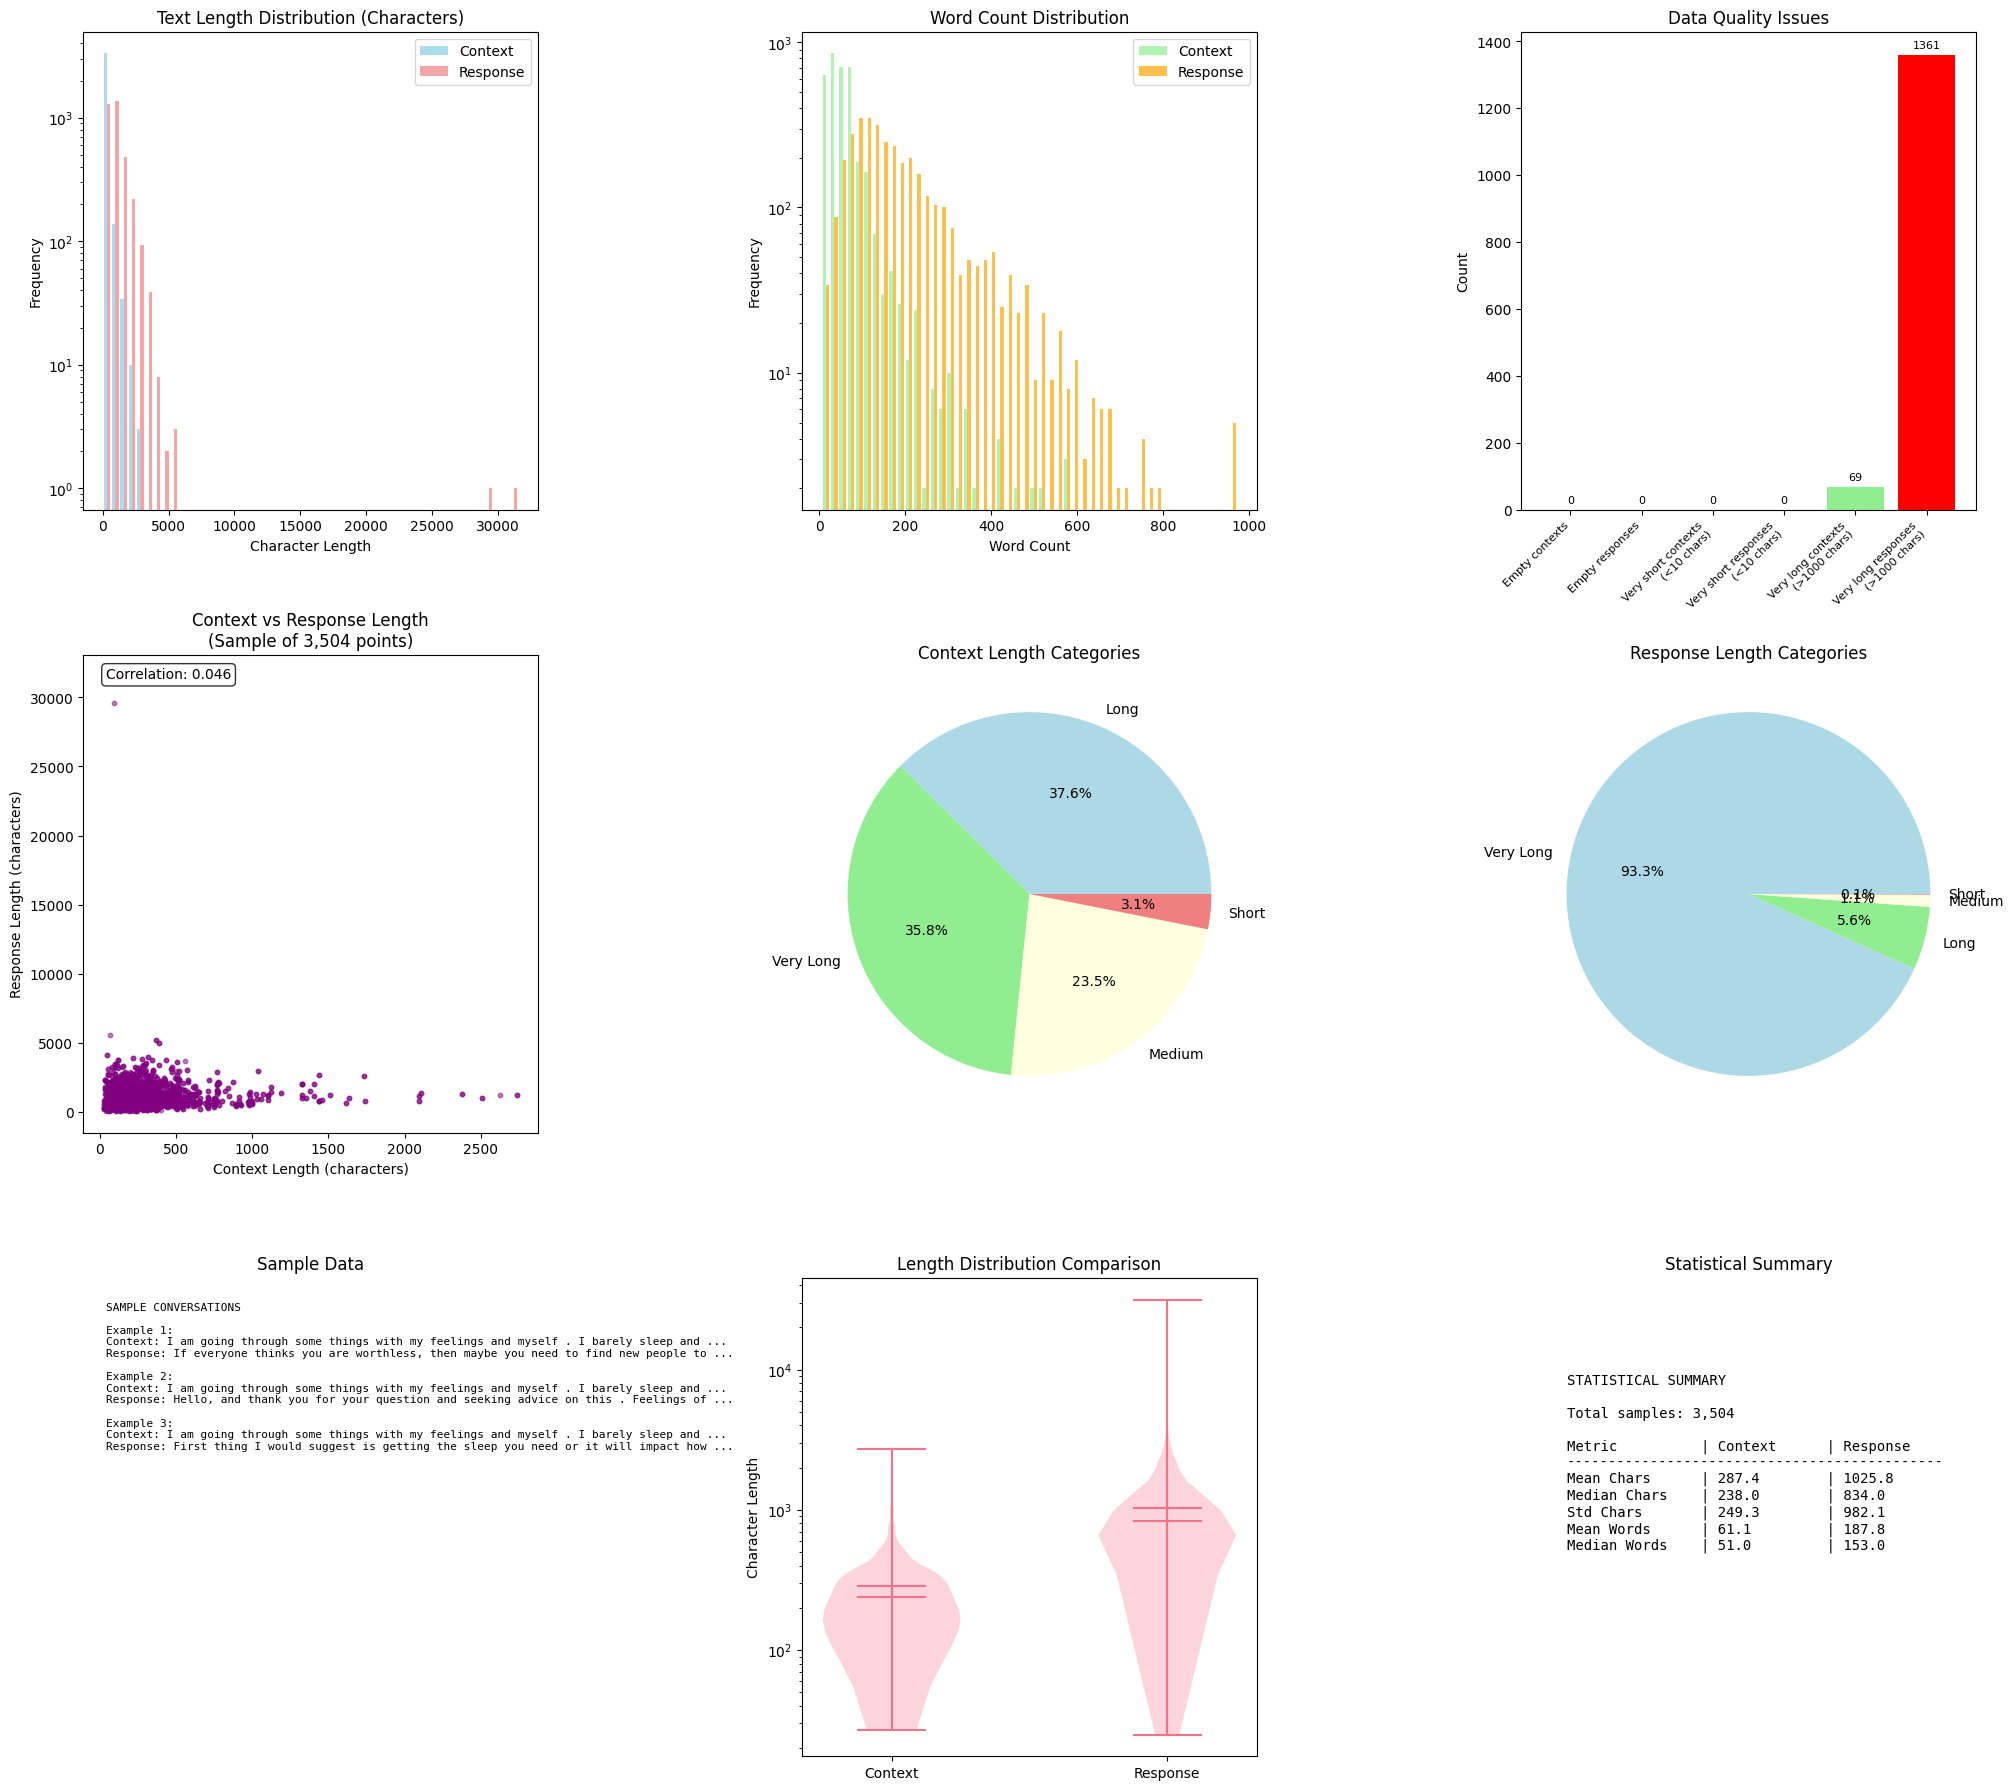

 Generating word clouds...
 Preparing text data...
   Context text length: 1,010,426 characters
   Response text length: 3,597,793 characters
 Creating context word cloud...
Creating response word cloud...
Word clouds saved to: /content/drive/MyDrive/research/data/dataset_wordclouds.png


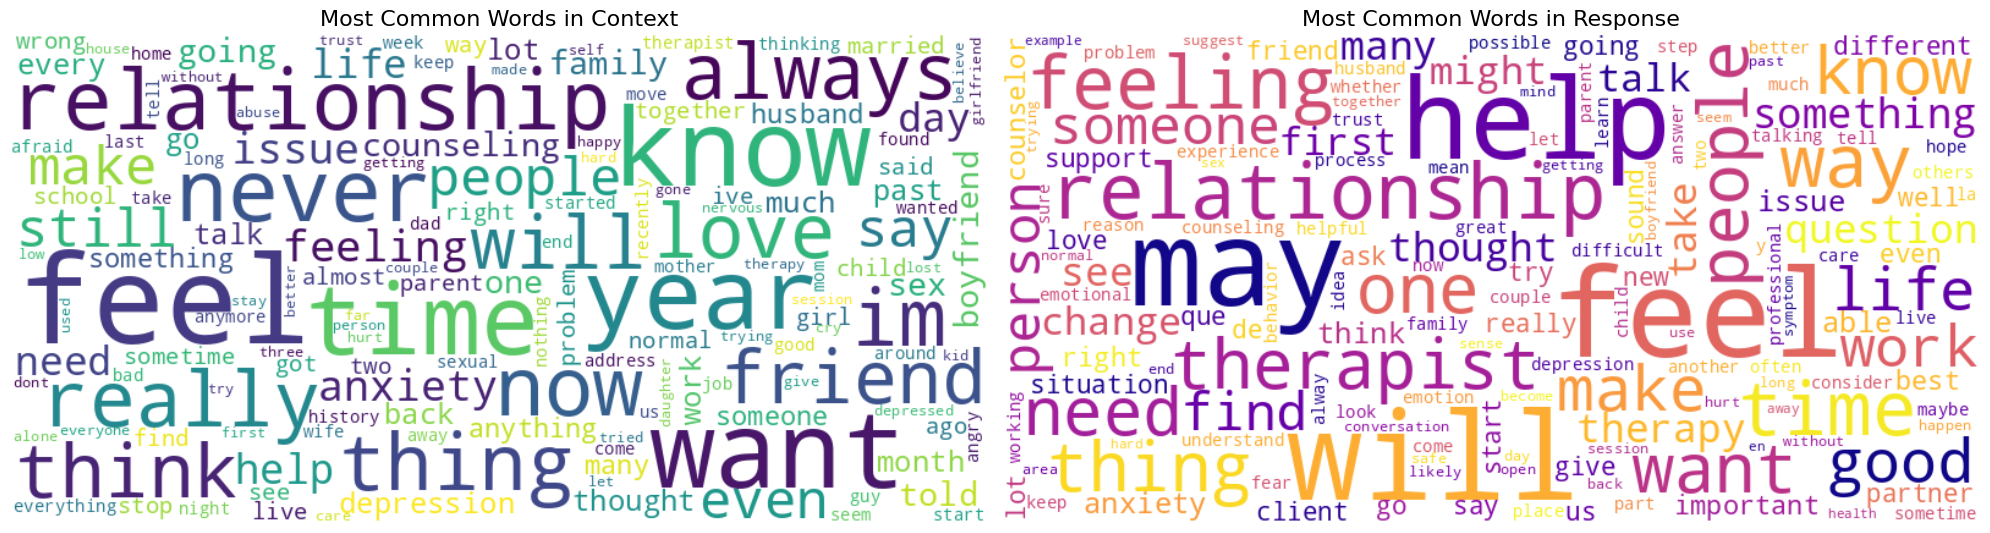


 Analysis complete!
Files saved to: /content/drive/MyDrive/research/data/
 Dataset analysis complete!


,context,response
0,I am going through some things with my feeling...,"If everyone thinks you are worthless, then may..."
1,I am going through some things with my feeling...,"Hello, and thank you for your question and see..."
2,I am going through some things with my feeling...,First thing I would suggest is getting the sle...
3,I am going through some things with my feeling...,Therapy is essential for those that are feelin...
4,I am going through some things with my feeling...,I first want to let you know that you are not ...
...,...,...
3507,My grandsons stepmother sends him to school wi...,Absolutely not ! It is never in a childs best ...
3508,My boyfriend is in recovery from drug addictio...,I am sorry you have tension between you and yo...
3509,The birth mother attempted suicide several tim...,"The true answer is, no one can really say with..."
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...


In [ ]:
# @title Specify input file and run preprocessing
def run_preprocessing():
    """Main function to run the preprocessing pipeline"""
    import os

    input_file = "/content/drive/MyDrive/research/data/mental_health.json"
    output_file = "/content/drive/MyDrive/research/data/therapy_dataset.csv"
    save_path = "/content/drive/MyDrive/research/data/"

    # Check Google Drive mount
    print(f"Google Drive mounted: {os.path.exists('/content/drive')}")
    print(f"MyDrive exists: {os.path.exists('/content/drive/MyDrive')}")

    # Check input file
    print(f"Input file path: {input_file}")
    print(f"Input file exists: {os.path.exists(input_file)}")

    if os.path.exists(input_file):
        file_size = os.path.getsize(input_file)
        print(f"Input file size: {file_size:,} bytes")

    # Check output directory
    output_dir = os.path.dirname(output_file)
    print(f"Output directory: {output_dir}")
    print(f"Output directory exists: {os.path.exists(output_dir)}")

    # Run the preprocessing
    result = preprocess_therapy_dataset(input_file, output_file)

    if os.path.exists(output_file):
        try:
            file_size = os.path.getsize(output_file)
            print(f"Output file size: {file_size:,} bytes")

            # Check file permissions
            file_stat = os.stat(output_file)
            print(f"File permissions: {oct(file_stat.st_mode)}")

            # Try to read first few lines to verify content
            with open(output_file, 'r', encoding='utf-8') as f:
                first_line = f.readline().strip()
                print(f"First line of output: {first_line[:100]}...")

        except Exception as e:
            print(f"Error checking output file: {e}")
    else:
        print("Output file was NOT created!")

        # Check if any CSV files were created in the directory
        try:
            csv_files = [f for f in os.listdir(output_dir) if f.endswith('.csv')]
            print(f"CSV files in output directory: {csv_files}")
        except:
            print("Cannot check for CSV files in output directory")

    if result is not None:
        print(f"\nSUCCESS! Preprocessing complete!")
        print(f"Saved to: {output_file}")
        try:
            analyzed_df = analyze_dataset(result, save_path)
            print(" Dataset analysis complete!")
        except Exception as e:
            print(f" Visualization failed: {e}")
            import traceback
            traceback.print_exc()

        return result
    else:
        print("\nPreprocessing failed")
        return None

# Run the test
test_therapy_cleaning()

# Run preprocessing with debug info
run_preprocessing()